In [1]:
# Auto-detect environment (Colab vs Local)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IS_COLAB = True
    print("✅ Running on Google Colab")
except ImportError:
    IS_COLAB = False
    print("✅ Running on Local Machine")

✅ Running on Local Machine


In [2]:
# STEP 2 (optional): NVIDIA driver / CUDA visibility diagnostics
# NOTE: This project uses TensorFlow/Keras. Mixing "auto-install" GPU PyTorch in the same kernel can
# destabilize CUDA on WSL (especially after pip uninstall/reinstall).
# Default behavior: diagnostics only (no installs).

import subprocess
import sys

RUN_TORCH_DIAGNOSTICS = False  # set True if you specifically want to check torch.cuda.is_available()
AUTO_INSTALL_CUDA_TORCH = False  # keep False for stability

def _run(cmd: list[str], timeout: int = 20) -> tuple[int, str]:
    try:
        completed = subprocess.run(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            check=False,
            timeout=timeout,
        )
        return completed.returncode, completed.stdout.strip()
    except Exception as e:
        return 1, str(e)

# NVIDIA driver visibility (authoritative in WSL)
rc, out = _run(["nvidia-smi"], timeout=10)
has_nvidia_smi = (rc == 0)
print("\n🔍 NVIDIA Driver (nvidia-smi):", "OK" if has_nvidia_smi else "NOT FOUND")
if out:
    print(out.splitlines()[0])

# Torch diagnostics are optional; leave off unless needed.
if RUN_TORCH_DIAGNOSTICS:
    try:
        import torch
        print("\n🔍 PyTorch:")
        print("torch.__version__:", torch.__version__)
        print("torch.version.cuda:", torch.version.cuda)
        print("torch.cuda.is_available():", torch.cuda.is_available())
        if torch.cuda.is_available():
            print("GPU:", torch.cuda.get_device_name(0))
    except Exception as e:
        print("⚠️ PyTorch diagnostics failed:", e)

if AUTO_INSTALL_CUDA_TORCH:
    raise RuntimeError(
        "AUTO_INSTALL_CUDA_TORCH is disabled for stability. "
        "If you really want it, install torch in a fresh venv and restart the kernel."
    )


🔍 NVIDIA Driver (nvidia-smi): OK
Mon Feb  2 05:19:48 2026       


In [3]:
# STEP 2b: TensorFlow device configuration (run this BEFORE building/training the model)
# Goal: be stable on WSL. We avoid mid-kernel package installs and we fail early if CUDA is broken.

import os
import platform

# Environment variables that must be set BEFORE importing tensorflow
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "1")  # quieter logs
os.environ.setdefault("TF_GPU_ALLOCATOR", "cuda_malloc_async")  # helps fragmentation/stability on many setups

import tensorflow as tf

system = platform.system()
is_wsl = bool(os.environ.get("WSL_INTEROP") or os.environ.get("WSL_DISTRO_NAME"))

# Choose mode here:
# - CPU mode is the most stable when CUDA/driver stack is flaky.
# - GPU mode requires a working WSL NVIDIA driver + compatible TF CUDA runtime.
USE_TF_GPU = False  # set True for GPU acceleration
REQUIRE_TF_GPU = False  # if True, error out when GPU isn't usable
ENABLE_MIXED_PRECISION = True  # only applied in GPU mode
GPU_SANITY_TEST = True  # runs a tiny matmul on GPU to catch broken CUDA early

print("\n🔍 TensorFlow Device Status:")
print("TensorFlow Version:", tf.__version__)
print("Platform:", system, "(WSL=" + str(is_wsl) + ")")
print("Built with CUDA:", tf.test.is_built_with_cuda())

# Helper: configure CPU-only mode (best-effort)
def _use_cpu_strategy():
    global ENABLE_MIXED_PRECISION, strategy
    ENABLE_MIXED_PRECISION = False
    strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")
    print("✅ Using CPU: OneDeviceStrategy(/CPU:0)")

if not USE_TF_GPU:
    # Best-effort: hide GPUs to prevent accidental placement on a flaky CUDA stack.
    # If TensorFlow was already imported/initialized earlier in the session, this may not take effect.
    try:
        tf.config.set_visible_devices([], "GPU")
    except Exception as e:
        print("⚠️ Could not hide GPUs (likely already initialized):", e)

    still_visible = tf.config.list_physical_devices("GPU")
    if still_visible:
        print("⚠️ GPUs are still visible in this session.")
        print("   For true CPU-only isolation: Restart the kernel, then run this cell first.")

    _use_cpu_strategy()
else:
    gpus = tf.config.list_physical_devices("GPU")
    print("GPUs visible to TensorFlow:", gpus)

    if not gpus:
        msg = (
            "TensorFlow does not see a GPU.\n"
            "- In WSL2, confirm 'nvidia-smi' works inside WSL.\n"
            "- Ensure you're using an NVIDIA Windows driver that supports WSL GPU.\n"
            "- Recommended install in this venv: pip install \"tensorflow[and-cuda]>=2.15,<2.16\"\n"
            "- Restart the Jupyter kernel after any install/driver change.\n"
        )
        print("⚠️ " + msg)
        if REQUIRE_TF_GPU:
            raise RuntimeError("❌ GPU required.\n\n" + msg)
        _use_cpu_strategy()
    else:
        # Avoid TF pre-allocating all VRAM (helps stability when other processes exist).
        for gpu in gpus:
            try:
                tf.config.experimental.set_memory_growth(gpu, True)
            except Exception as e:
                print(f"⚠️ Could not set memory growth for {gpu}: {e}")

        # Prefer a single-GPU strategy if only one GPU exists (simpler/more stable).
        if len(gpus) == 1:
            strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
        else:
            strategy = tf.distribute.MirroredStrategy()
        print(f"✅ Using strategy: {type(strategy).__name__} (replicas={getattr(strategy, 'num_replicas_in_sync', '?')})")

        if ENABLE_MIXED_PRECISION:
            try:
                from tensorflow.keras import mixed_precision
                mixed_precision.set_global_policy("mixed_float16")
                print("✅ Mixed precision enabled: mixed_float16")
            except Exception as e:
                print(f"⚠️ Mixed precision not enabled: {e}")

        if GPU_SANITY_TEST:
            try:
                with tf.device("/GPU:0"):
                    a = tf.random.uniform((512, 512), dtype=tf.float32)
                    b = tf.random.uniform((512, 512), dtype=tf.float32)
                    c = tf.matmul(a, b)
                    _ = float(tf.reduce_sum(c).numpy())
                print("✅ GPU sanity test passed")
            except Exception as e:
                # Important: after a CUDA failure, the safest recovery is a kernel restart.
                raise RuntimeError(
                    "❌ GPU sanity test failed (CUDA stack looks unstable).\n"
                    "Fix (most reliable):\n"
                    "1) Restart the Jupyter kernel\n"
                    "2) Set USE_TF_GPU=False to run stable CPU, OR\n"
                    "3) Repair WSL GPU stack (driver + TF CUDA runtime) then re-enable USE_TF_GPU.\n\n"
                    f"Original error: {e}"
                )


🔍 TensorFlow Device Status:
TensorFlow Version: 2.20.0
Platform: Linux (WSL=True)
Built with CUDA: True
⚠️ GPUs are still visible in this session.
   For true CPU-only isolation: Restart the kernel, then run this cell first.
✅ Using CPU: OneDeviceStrategy(/CPU:0)


W0000 00:00:1770009620.692633  427058 gpu_device.cc:2431] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [ ]:
# STEP 3 (corrected): Recursive loader for patient subfolders and mask pairing
import os
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Auto-detect dataset path based on environment
if IS_COLAB:
    # Google Colab path
    LGG_ROOT = "/content/drive/MyDrive/Datasets/Brain MRI segmentation/kaggle_3m"
else:
    # Local machine path - adjust this to your actual dataset location
    # If you don't have the raw dataset locally, skip this cell and use Cell 6 instead
    LGG_ROOT = "C:/Users/KIIT/Desktop/Datasets/Brain_MRI_segmentation/kaggle_3m"
    if not os.path.exists(LGG_ROOT):
        print("⚠️ Raw dataset not found locally.")
        print("   → Skip this cell and run Cell 6 to load preprocessed data directly.")
        LGG_ROOT = None

print(f"Dataset Root: {LGG_ROOT}")

# Supported image/mask extensions (order matters: mask suffix handled separately)
IMG_EXTS = (".tif", ".tiff", ".png", ".jpg", ".jpeg")

# Containers
image_paths = []
mask_paths = []

def find_pairs_in_patient_folder(patient_folder):
    """Find (image, mask) pairs inside a patient folder.
       Masks are expected to contain '_mask' before the extension (e.g. '..._1_mask.tif').
    """
    files = sorted(os.listdir(patient_folder))
    # index files by name for fast lookup
    file_set = set(files)
    pairs = []

    for f in files:
        lf = f.lower()
        # consider only potential mask files (having '_mask' in name)
        if "_mask" in lf:
            name_no_mask, ext = os.path.splitext(f)
            # verify extension
            if ext.lower() not in IMG_EXTS:
                continue
            # derive image filename candidates by removing the last "_mask" occurrence
            # e.g. "TCGA_..._1_mask.tif" -> "TCGA_..._1.tif"
            img_base = name_no_mask.rsplit("_mask", 1)[0]
            # try same extension first
            candidate = img_base + ext
            if candidate in file_set:
                pairs.append((os.path.join(patient_folder, candidate), os.path.join(patient_folder, f)))
                continue
            # try other extensions if candidate not found
            found = False
            for e in IMG_EXTS:
                candidate_e = img_base + e
                if candidate_e in file_set:
                    pairs.append((os.path.join(patient_folder, candidate_e), os.path.join(patient_folder, f)))
                    found = True
                    break
            # if not found, skip but report later
    return pairs

# Walk one level deep in LGG_ROOT (each patient folder contains slices)
print("Scanning patient folders and pairing image/mask files...")
for entry in sorted(os.listdir(LGG_ROOT)):
    p = os.path.join(LGG_ROOT, entry)
    if os.path.isdir(p):
        pairs = find_pairs_in_patient_folder(p)
        for img_p, mask_p in pairs:
            image_paths.append(img_p)
            mask_paths.append(mask_p)

# Safety check
if len(image_paths) == 0:
    raise FileNotFoundError(f"No image/mask pairs found under {LGG_ROOT}. Please check the dataset path and folder structure.")

print(f"Total pairs found: {len(image_paths)}")

# Optional: if dataset is extremely large and limited RAM is available, a subset can be used:
# MAX_SAMPLES = 5000
# if len(image_paths) > MAX_SAMPLES:
#     image_paths = image_paths[:MAX_SAMPLES]
#     mask_paths = mask_paths[:MAX_SAMPLES]
#     print(f"Using subset of {MAX_SAMPLES} samples to conserve RAM.")

# Load, preprocess, and store in numpy arrays
IMG_SIZE = 256  # target size
images = []
masks = []

print("Loading and preprocessing images (this may take a while)...")
for img_p, mask_p in tqdm(zip(image_paths, mask_paths), total=len(image_paths)):
    # read image - keep as grayscale
    img = cv2.imread(img_p, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_p, cv2.IMREAD_GRAYSCALE)

    if img is None or mask is None:
        # Skip corrupted or unreadable files but report
        print(f"Warning: failed to read pair: {img_p} / {mask_p}")
        continue

    # Resize
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # Normalize image to [0,1]
    img = img.astype(np.float32) / 255.0

    # Binarize mask: treat any non-zero as tumour (0/1)
    mask = (mask > 0).astype(np.float32)

    # Add channel dimension
    img = np.expand_dims(img, axis=-1)   # shape (H,W,1)
    mask = np.expand_dims(mask, axis=-1) # shape (H,W,1)

    images.append(img)
    masks.append(mask)

# Convert to numpy arrays
images = np.array(images, dtype=np.float32)
masks = np.array(masks, dtype=np.float32)

print("Preprocessing finished.")
print("Images shape:", images.shape)
print("Masks shape: ", masks.shape)

# Shuffle and split: Train 70%, Val 15%, Test 15%
X_train, X_temp, y_train, y_temp = train_test_split(images, masks, test_size=0.30, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, shuffle=True)

print("\nDataset split:")
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

# Quick sanity visualisation of 4 random samples
import random
idxs = random.sample(range(len(X_train)), min(4, len(X_train)))
fig, axs = plt.subplots(4, 2, figsize=(8, 12))

for i, idx in enumerate(idxs):
    axs[i,0].imshow(X_train[idx].squeeze(), cmap='gray')
    axs[i,0].set_title("Input")
    axs[i,1].imshow(y_train[idx].squeeze(), cmap='gray')
    axs[i,1].set_title("Mask")
    axs[i,0].axis('off'); axs[i,1].axis('off')
plt.tight_layout()
plt.show()

In [4]:
import numpy as np
import os

# Auto-detect preprocessed data path
if IS_COLAB:
    BASE_PATH = "/content/drive/MyDrive/LGGData/processed_splits"
else:
    # Local machine - use the processed_splits folder in current directory
    BASE_PATH = "processed_splits"
    # Or use absolute path:
    # BASE_PATH = "C:/Users/KIIT/Desktop/open-source/resunet/processed_splits"

print(f"📂 Loading preprocessed data from: {BASE_PATH}")

if not os.path.exists(BASE_PATH):
    raise FileNotFoundError(f"❌ Preprocessed data not found at: {BASE_PATH}")

X_train = np.load(f"{BASE_PATH}/X_train.npy")
y_train = np.load(f"{BASE_PATH}/y_train.npy")

X_val   = np.load(f"{BASE_PATH}/X_val.npy")
y_val   = np.load(f"{BASE_PATH}/y_val.npy")

X_test  = np.load(f"{BASE_PATH}/X_test.npy")
y_test  = np.load(f"{BASE_PATH}/y_test.npy")

print("\n✅ Data loaded successfully:")
print("   Train:", X_train.shape, y_train.shape)
print("   Val  :", X_val.shape, y_val.shape)
print("   Test :", X_test.shape, y_test.shape)

📂 Loading preprocessed data from: processed_splits

✅ Data loaded successfully:
   Train: (2750, 256, 256, 1) (2750, 256, 256, 1)
   Val  : (589, 256, 256, 1) (589, 256, 256, 1)
   Test : (590, 256, 256, 1) (590, 256, 256, 1)




### Step 4: Building the ResUpNet Model (Residual U-Net + ResNet50 Encoder + Attention Skip Fusion)



In [5]:

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sdist
import cv2
import os
import math



def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (
        tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth
    )

def combo_loss(y_true, y_pred):
    # Keep loss math in float32 even if mixed precision is enabled.
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dice_loss(y_true, y_pred) + tf.keras.losses.binary_crossentropy(y_true, y_pred)

def focal_loss(gamma=2., alpha=0.25):
    def loss_fn(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        eps = K.epsilon()
        y_pred_f = K.clip(y_pred_f, eps, 1. - eps)
        pt = tf.where(tf.equal(y_true_f, 1), y_pred_f, 1 - y_pred_f)
        w = alpha * K.pow(1. - pt, gamma)
        fl = - w * K.log(pt)
        return K.mean(fl)
    return loss_fn

def hybrid_loss(alpha=0.5, gamma=2.0):
    fl = focal_loss(gamma=gamma, alpha=0.25)
    def loss(y_true, y_pred):
        return alpha * dice_loss(y_true, y_pred) + (1.0 - alpha) * fl(y_true, y_pred)
    return loss

def iou_metric(y_true, y_pred, thresh=0.5, smooth=1e-6):
    y_pred = tf.cast(y_pred > thresh, tf.float32)
    inter = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)



def iou_keras(y_true, y_pred): return iou_metric(y_true, y_pred)
def precision_keras(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    predicted_positive = tf.reduce_sum(y_pred)
    return tp / (predicted_positive + K.epsilon())

def recall_keras(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    tp = tf.reduce_sum(y_true * y_pred)
    actual_positive = tf.reduce_sum(y_true)
    return tp / (actual_positive + K.epsilon())

def f1_keras(y_true, y_pred):
    p = precision_keras(y_true, y_pred)
    r = recall_keras(y_true, y_pred)
    return 2 * p * r / (p + r + K.epsilon())



def attention_gate(x, g, inter_channels):
    """
    Simple attention gate as in Attention U-Net.
    x: skip connection feature map
    g: gating signal (decoder)
    """
    theta_x = layers.Conv2D(inter_channels, 1, strides=1, padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, 1, strides=1, padding='same')(g)
    add = layers.Add()([theta_x, phi_g])
    relu = layers.Activation('relu')(add)
    psi = layers.Conv2D(1, 1, strides=1, padding='same')(relu)
    sig = layers.Activation('sigmoid')(psi)


    out = layers.Multiply()([x, sig])
    return out



def residual_conv_block(x, filters, kernel_size=3):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    # Project shortcut if needed
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x



def build_resupnet(input_shape=(256,256,1), pretrained=True, train_encoder=True):
    """
    ResUpNet:
     - input_shape: grayscale (H,W,1)
     - pretrained: use ImageNet weights for ResNet50 encoder
     - train_encoder: whether encoder layers are trainable
    """
    # Input and convert to 3-channel required by ResNet50
    inp = layers.Input(shape=input_shape, name='input_image')
    # repeat channels to make 3 channels
    x = layers.Concatenate()([inp, inp, inp])  # shape -> (H,W,3)

    # Pretrained ResNet50 encoder
    base = ResNet50(include_top=False, weights='imagenet' if pretrained else None, input_tensor=x)
    base.trainable = train_encoder

    skips = [
        base.get_layer('conv1_relu').output,         # 128x128
        base.get_layer('conv2_block3_out').output,   # 64x64
        base.get_layer('conv3_block4_out').output,   # 32x32
        base.get_layer('conv4_block6_out').output    # 16x16
    ]
    bottleneck = base.get_layer('conv5_block3_out').output  # 8x8

    # Decoder: progressive upsampling, attention on skip, residual conv blocks
    d = bottleneck
    filters = [512, 256, 128, 64]  # matching decoder filters

    for i, f in enumerate(filters):
        # upsample
        d = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(d)
        # attention gate on skip connection
        skip = skips[-(i+1)]
        att = attention_gate(skip, d, inter_channels=f//4)
        # concatenate
        d = layers.Concatenate()([d, att])
        # residual conv block
        d = residual_conv_block(d, f)

    # Final upsample to original resolution (from 128 -> 256 if needed)
    d = layers.UpSampling2D(size=(2,2), interpolation='bilinear')(d)
    d = residual_conv_block(d, 32)

    # Output
    # Use float32 output for numeric stability when mixed precision is enabled.
    out = layers.Conv2D(1, (1,1), padding='same', activation='sigmoid', name='mask', dtype='float32')(d)

    model = models.Model(inputs=inp, outputs=out, name='ResUpNet')
    return model

In [6]:
import tensorflow as tf

# Build/compile inside the distribution strategy so variables are placed correctly.
# NOTE: Device choice (CPU vs GPU) is controlled in Cell 3 (TensorFlow device configuration).
tf.keras.backend.clear_session()

try:
    strategy
except NameError:
    strategy = tf.distribute.get_strategy()

with strategy.scope():
    model = build_resupnet()

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=combo_loss,
        metrics=[
            'accuracy',
            dice_coef,
            tf.keras.metrics.MeanIoU(num_classes=2),
        ],
    )

model.summary()

print("\n🔧 Physical devices:")
print("  GPU:", tf.config.list_physical_devices("GPU"))
print("  CPU:", tf.config.list_physical_devices("CPU"))
print("🔧 Strategy:", type(strategy).__name__, "replicas=", getattr(strategy, "num_replicas_in_sync", "?"))

# Quick placement check (helps confirm whether you're actually running GPU or CPU)
t = tf.constant(0.0)
print("🔧 Example tensor device:", t.device)

Model: "ResUpNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 3)                │            │ input_image[0][0… │
│                     │                   │            │ input_image[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ concatenate[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 46,373,013 (176.90 MB)

 Trainable params: 46,313,941 (176.67 MB)

 Non-trainable params: 59,072 (230.75 KB)


🔧 Physical devices:
  GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
  CPU: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
🔧 Strategy: OneDeviceStrategy replicas= 1
🔧 Example tensor device: /job:localhost/replica:0/task:0/device:CPU:0


In [ ]:
#2nd trial

In [7]:
import numpy as np
import scipy.spatial.distance as sdist
from skimage import measure



def dice_np(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    inter = np.sum(y_true_f * y_pred_f)
    return (2. * inter + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou_np(y_true, y_pred, smooth=1e-6):
    inter = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - inter
    return (inter + smooth) / (union + smooth)

def precision_np(y_true, y_pred, smooth=1e-6):
    tp = np.sum(y_true * y_pred)
    fp = np.sum((1 - y_true) * y_pred)
    return tp / (tp + fp + smooth)

def recall_np(y_true, y_pred, smooth=1e-6):
    tp = np.sum(y_true * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    return tp / (tp + fn + smooth)

def f1_np(y_true, y_pred, smooth=1e-6):
    p = precision_np(y_true, y_pred)
    r = recall_np(y_true, y_pred)
    return (2 * p * r) / (p + r + smooth)

def specificity_np(y_true, y_pred, smooth=1e-6):
    tn = np.sum((1 - y_true) * (1 - y_pred))
    fp = np.sum((1 - y_true) * y_pred)
    return tn / (tn + fp + smooth)

def hd95_np(y_true, y_pred):
    y_true_pts = np.argwhere(y_true > 0)
    y_pred_pts = np.argwhere(y_pred > 0)

    if len(y_true_pts) == 0 or len(y_pred_pts) == 0:
        return 0.0  # safe fallback

    d1 = sdist.cdist(y_true_pts, y_pred_pts)
    d2 = sdist.cdist(y_pred_pts, y_true_pts)
    return max(np.percentile(d1.min(axis=1), 95),
               np.percentile(d2.min(axis=1), 95))

def asd_np(y_true, y_pred):
    """
    Average Surface Distance (ASD)
    Computes mean bidirectional surface distance
    """

    # Ensure binary
    y_true = y_true.squeeze()
    y_pred = y_pred.squeeze()

    # Extract contours (surface pixels)
    true_contours = measure.find_contours(y_true, 0.5)
    pred_contours = measure.find_contours(y_pred, 0.5)

    if len(true_contours) == 0 or len(pred_contours) == 0:
        return 0.0  # safe fallback (no tumor)

    # Stack contour points
    true_pts = np.vstack(true_contours)
    pred_pts = np.vstack(pred_contours)

    # Pairwise distances
    d_true_to_pred = sdist.cdist(true_pts, pred_pts)
    d_pred_to_true = sdist.cdist(pred_pts, true_pts)

    # Mean of minimum distances
    asd = (np.mean(d_true_to_pred.min(axis=1)) +
           np.mean(d_pred_to_true.min(axis=1))) / 2.0

    return asd

In [8]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.spatial.distance as sdist

class EpochEvaluationCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val, threshold=0.5, max_samples=None):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.threshold = threshold
        self.max_samples = max_samples


    def on_epoch_end(self, epoch, logs=None):
        all_dice, all_iou, all_prec, all_rec, all_f1 = [], [], [], [], []
        all_hd95, all_asd = [], []

        idxs = range(len(self.X_val))
        if self.max_samples:
            idxs = list(idxs)[:self.max_samples]

        for i in idxs:
            x = self.X_val[i:i+1]
            y_true = self.y_val[i].squeeze()

            y_prob = self.model.predict(x, verbose=0)[0, ..., 0]
            y_pred = (y_prob > self.threshold).astype(np.float32)

            d = dice_np(y_true, y_pred)
            j = iou_np(y_true, y_pred)
            p = precision_np(y_true, y_pred)
            r = recall_np(y_true, y_pred)
            f1 = f1_np(y_true, y_pred)

            h = hd95_np(y_true, y_pred)
            a = asd_np(y_true, y_pred)

            all_dice.append(d)
            all_iou.append(j)
            all_prec.append(p)
            all_rec.append(r)
            all_f1.append(f1)
            all_hd95.append(h)
            all_asd.append(a)

        print(f"\n📊 Epoch {epoch+1} — Validation Metrics:")
        print(f"Dice:      {np.nanmean(all_dice):.4f}")
        print(f"IoU:       {np.nanmean(all_iou):.4f}")
        print(f"Precision: {np.nanmean(all_prec):.4f}")
        print(f"Recall:    {np.nanmean(all_rec):.4f}")
        print(f"F1:        {np.nanmean(all_f1):.4f}")
        print(f"HD95(px):  {np.nanmean(all_hd95):.2f}")
        print(f"ASD(px):   {np.nanmean(all_asd):.2f}")

In [9]:
epoch_eval_cb = EpochEvaluationCallback(
    X_val, y_val,
    threshold=0.5,  # Lowered from 0.5 to detect early predictions
    max_samples=50
)

In [10]:
import os
import numpy as np
import tensorflow as tf

from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    ReduceLROnPlateau,
    EarlyStopping
)

import scipy.spatial.distance as sdist
import matplotlib.pyplot as plt

print("\n🔧 Training will run with:")
print("   GPUs:", tf.config.list_physical_devices("GPU"))
try:
    strategy
    print("   Strategy:", type(strategy).__name__, "replicas=", getattr(strategy, "num_replicas_in_sync", "?"))
except NameError:
    pass

callbacks = [
    ModelCheckpoint(
        "best_resupnet.keras",
        monitor="val_dice_coef",
        save_best_only=True,
        mode="max",
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_dice_coef",
        factor=0.50,
        patience=3,
        min_lr=1e-6,
        mode="max",
        verbose=1
    ),
    EarlyStopping(
        monitor="val_dice_coef",
        mode="max",
        patience=8,
        restore_best_weights=True,
        verbose=1,
    ),
    epoch_eval_cb,
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=22,
    batch_size=16,
    shuffle=True,
    callbacks=callbacks
)


🔧 Training will run with:
   GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
   Strategy: OneDeviceStrategy replicas= 1


2026-02-02 05:21:19.433981: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 1/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8102 - dice_coef: 0.0611 - loss: 1.4262 - mean_io_u: 0.4950

2026-02-02 05:32:35.042260: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 1: val_dice_coef improved from None to 0.01736, saving model to best_resupnet.keras


2026-02-02 05:33:12.088564: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 1: finished saving model to best_resupnet.keras

📊 Epoch 1 — Validation Metrics:
Dice:      0.7600
IoU:       0.7600
Precision: 0.0000
Recall:    0.0000
F1:        0.0000
HD95(px):  0.00
ASD(px):   0.00
172/172 ━━━━━━━━━━━━━━━━━━━━ 727s 4s/step - accuracy: 0.9400 - dice_coef: 0.0967 - loss: 1.1562 - mean_io_u: 0.4949 - val_accuracy: 0.9905 - val_dice_coef: 0.0174 - val_loss: 1.1749 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 2/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9933 - dice_coef: 0.1772 - loss: 0.9208 - mean_io_u: 0.4947

2026-02-02 05:44:29.076513: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 2: val_dice_coef did not improve from 0.01736


2026-02-02 05:45:04.144511: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



📊 Epoch 2 — Validation Metrics:
Dice:      0.7600
IoU:       0.7600
Precision: 0.0000
Recall:    0.0000
F1:        0.0000
HD95(px):  0.00
ASD(px):   0.00
172/172 ━━━━━━━━━━━━━━━━━━━━ 708s 4s/step - accuracy: 0.9938 - dice_coef: 0.1875 - loss: 0.9022 - mean_io_u: 0.4949 - val_accuracy: 0.9905 - val_dice_coef: 0.0165 - val_loss: 1.0885 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 3/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9948 - dice_coef: 0.2490 - loss: 0.8204 - mean_io_u: 0.4946

2026-02-02 05:56:17.016197: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 3: val_dice_coef did not improve from 0.01736


2026-02-02 05:56:52.897777: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



📊 Epoch 3 — Validation Metrics:
Dice:      0.7600
IoU:       0.7600
Precision: 0.0000
Recall:    0.0000
F1:        0.0000
HD95(px):  0.00
ASD(px):   0.00
172/172 ━━━━━━━━━━━━━━━━━━━━ 707s 4s/step - accuracy: 0.9952 - dice_coef: 0.2472 - loss: 0.8173 - mean_io_u: 0.4951 - val_accuracy: 0.9905 - val_dice_coef: 0.0149 - val_loss: 1.0620 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 4/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9963 - dice_coef: 0.2805 - loss: 0.7697 - mean_io_u: 0.4953

2026-02-02 06:08:09.124873: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 4: val_dice_coef improved from 0.01736 to 0.06240, saving model to best_resupnet.keras


2026-02-02 06:08:44.928919: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 4: finished saving model to best_resupnet.keras

📊 Epoch 4 — Validation Metrics:
Dice:      0.7101
IoU:       0.6972
Precision: 0.0770
Recall:    0.0383
F1:        0.0501
HD95(px):  1.78
ASD(px):   0.83
172/172 ━━━━━━━━━━━━━━━━━━━━ 716s 4s/step - accuracy: 0.9962 - dice_coef: 0.3162 - loss: 0.7309 - mean_io_u: 0.4949 - val_accuracy: 0.9910 - val_dice_coef: 0.0624 - val_loss: 0.9967 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 5/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9962 - dice_coef: 0.3616 - loss: 0.6768 - mean_io_u: 0.4950

2026-02-02 06:20:04.398922: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 5: val_dice_coef improved from 0.06240 to 0.27343, saving model to best_resupnet.keras


2026-02-02 06:20:40.730437: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 5: finished saving model to best_resupnet.keras

📊 Epoch 5 — Validation Metrics:
Dice:      0.8889
IoU:       0.8655
Precision: 0.2107
Recall:    0.1499
F1:        0.1689
HD95(px):  2.07
ASD(px):   0.96
172/172 ━━━━━━━━━━━━━━━━━━━━ 716s 4s/step - accuracy: 0.9960 - dice_coef: 0.3799 - loss: 0.6570 - mean_io_u: 0.4950 - val_accuracy: 0.9948 - val_dice_coef: 0.2734 - val_loss: 0.7639 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 6/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9971 - dice_coef: 0.4452 - loss: 0.5827 - mean_io_u: 0.4950

2026-02-02 06:31:54.050249: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 6: val_dice_coef improved from 0.27343 to 0.39338, saving model to best_resupnet.keras


2026-02-02 06:32:29.456945: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 6: finished saving model to best_resupnet.keras

📊 Epoch 6 — Validation Metrics:
Dice:      0.9329
IoU:       0.9134
Precision: 0.2201
Recall:    0.2098
F1:        0.2129
HD95(px):  0.91
ASD(px):   0.57
172/172 ━━━━━━━━━━━━━━━━━━━━ 710s 4s/step - accuracy: 0.9972 - dice_coef: 0.4682 - loss: 0.5579 - mean_io_u: 0.4949 - val_accuracy: 0.9962 - val_dice_coef: 0.3934 - val_loss: 0.6337 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 7/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9976 - dice_coef: 0.5383 - loss: 0.4823 - mean_io_u: 0.4948

2026-02-02 06:43:44.194412: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 7: val_dice_coef did not improve from 0.39338


2026-02-02 06:44:21.715718: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



📊 Epoch 7 — Validation Metrics:
Dice:      0.9261
IoU:       0.9009
Precision: 0.2264
Recall:    0.1692
F1:        0.1861
HD95(px):  2.93
ASD(px):   1.07
172/172 ━━━━━━━━━━━━━━━━━━━━ 708s 4s/step - accuracy: 0.9975 - dice_coef: 0.5460 - loss: 0.4740 - mean_io_u: 0.4949 - val_accuracy: 0.9951 - val_dice_coef: 0.3278 - val_loss: 0.7055 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 8/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9973 - dice_coef: 0.5990 - loss: 0.4190 - mean_io_u: 0.4949

2026-02-02 06:55:32.431681: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 8: val_dice_coef improved from 0.39338 to 0.53555, saving model to best_resupnet.keras


2026-02-02 06:56:07.912271: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 8: finished saving model to best_resupnet.keras


2026-02-02 06:56:37.969253: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



📊 Epoch 8 — Validation Metrics:
Dice:      0.9678
IoU:       0.9467
Precision: 0.2231
Recall:    0.1998
F1:        0.2078
HD95(px):  1.36
ASD(px):   0.67
172/172 ━━━━━━━━━━━━━━━━━━━━ 725s 4s/step - accuracy: 0.9975 - dice_coef: 0.6202 - loss: 0.3967 - mean_io_u: 0.4950 - val_accuracy: 0.9963 - val_dice_coef: 0.5356 - val_loss: 0.4863 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 9/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9981 - dice_coef: 0.6717 - loss: 0.3411 - mean_io_u: 0.4952

2026-02-02 07:07:34.476665: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 9: val_dice_coef improved from 0.53555 to 0.63076, saving model to best_resupnet.keras


2026-02-02 07:08:09.677855: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 9: finished saving model to best_resupnet.keras


2026-02-02 07:08:40.078286: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



📊 Epoch 9 — Validation Metrics:
Dice:      0.9785
IoU:       0.9624
Precision: 0.2232
Recall:    0.2158
F1:        0.2185
HD95(px):  0.62
ASD(px):   0.39
172/172 ━━━━━━━━━━━━━━━━━━━━ 723s 4s/step - accuracy: 0.9980 - dice_coef: 0.7016 - loss: 0.3111 - mean_io_u: 0.4949 - val_accuracy: 0.9969 - val_dice_coef: 0.6308 - val_loss: 0.3873 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 10/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9981 - dice_coef: 0.7321 - loss: 0.2791 - mean_io_u: 0.4948

2026-02-02 07:19:39.496830: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 10: val_dice_coef improved from 0.63076 to 0.68099, saving model to best_resupnet.keras


2026-02-02 07:20:14.702656: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 10: finished saving model to best_resupnet.keras

📊 Epoch 10 — Validation Metrics:
Dice:      0.8551
IoU:       0.8371
Precision: 0.2014
Recall:    0.2341
F1:        0.2151
HD95(px):  0.71
ASD(px):   0.50
172/172 ━━━━━━━━━━━━━━━━━━━━ 710s 4s/step - accuracy: 0.9980 - dice_coef: 0.7355 - loss: 0.2760 - mean_io_u: 0.4952 - val_accuracy: 0.9961 - val_dice_coef: 0.6810 - val_loss: 0.3395 - val_mean_io_u: 0.5033 - learning_rate: 1.0000e-04
Epoch 11/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9981 - dice_coef: 0.7815 - loss: 0.2290 - mean_io_u: 0.4948

2026-02-02 07:31:34.768771: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 11: val_dice_coef did not improve from 0.68099


2026-02-02 07:32:10.877471: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



📊 Epoch 11 — Validation Metrics:
Dice:      0.9172
IoU:       0.8908
Precision: 0.2314
Recall:    0.1553
F1:        0.1772
HD95(px):  3.40
ASD(px):   1.18
172/172 ━━━━━━━━━━━━━━━━━━━━ 711s 4s/step - accuracy: 0.9979 - dice_coef: 0.7707 - loss: 0.2405 - mean_io_u: 0.4950 - val_accuracy: 0.9910 - val_dice_coef: 0.4160 - val_loss: 0.6290 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 12/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9979 - dice_coef: 0.8024 - loss: 0.2086 - mean_io_u: 0.4947

2026-02-02 07:43:27.350731: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 12: val_dice_coef improved from 0.68099 to 0.74313, saving model to best_resupnet.keras


2026-02-02 07:44:02.952558: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 12: finished saving model to best_resupnet.keras

📊 Epoch 12 — Validation Metrics:
Dice:      0.9608
IoU:       0.9456
Precision: 0.2230
Recall:    0.2196
F1:        0.2208
HD95(px):  0.55
ASD(px):   0.38
172/172 ━━━━━━━━━━━━━━━━━━━━ 716s 4s/step - accuracy: 0.9980 - dice_coef: 0.7948 - loss: 0.2151 - mean_io_u: 0.4950 - val_accuracy: 0.9970 - val_dice_coef: 0.7431 - val_loss: 0.2738 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 13/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9983 - dice_coef: 0.8121 - loss: 0.1968 - mean_io_u: 0.4955

2026-02-02 07:55:17.453872: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 13: val_dice_coef improved from 0.74313 to 0.77452, saving model to best_resupnet.keras


2026-02-02 07:55:52.766065: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 13: finished saving model to best_resupnet.keras

📊 Epoch 13 — Validation Metrics:
Dice:      0.9608
IoU:       0.9463
Precision: 0.2186
Recall:    0.2252
F1:        0.2208
HD95(px):  0.43
ASD(px):   0.35
172/172 ━━━━━━━━━━━━━━━━━━━━ 710s 4s/step - accuracy: 0.9984 - dice_coef: 0.8303 - loss: 0.1781 - mean_io_u: 0.4950 - val_accuracy: 0.9974 - val_dice_coef: 0.7745 - val_loss: 0.2394 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 14/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9985 - dice_coef: 0.8497 - loss: 0.1580 - mean_io_u: 0.4948

2026-02-02 08:07:11.852170: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 14: val_dice_coef improved from 0.77452 to 0.77722, saving model to best_resupnet.keras


2026-02-02 08:07:48.569166: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 14: finished saving model to best_resupnet.keras

📊 Epoch 14 — Validation Metrics:
Dice:      0.9587
IoU:       0.9430
Precision: 0.2192
Recall:    0.2217
F1:        0.2187
HD95(px):  0.60
ASD(px):   0.43
172/172 ━━━━━━━━━━━━━━━━━━━━ 715s 4s/step - accuracy: 0.9985 - dice_coef: 0.8528 - loss: 0.1549 - mean_io_u: 0.4949 - val_accuracy: 0.9973 - val_dice_coef: 0.7772 - val_loss: 0.2387 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 15/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9986 - dice_coef: 0.8736 - loss: 0.1336 - mean_io_u: 0.4947

2026-02-02 08:19:09.642091: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 15: val_dice_coef improved from 0.77722 to 0.80164, saving model to best_resupnet.keras


2026-02-02 08:19:45.440783: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 15: finished saving model to best_resupnet.keras

📊 Epoch 15 — Validation Metrics:
Dice:      0.9423
IoU:       0.9282
Precision: 0.2220
Recall:    0.2240
F1:        0.2223
HD95(px):  0.50
ASD(px):   0.32
172/172 ━━━━━━━━━━━━━━━━━━━━ 717s 4s/step - accuracy: 0.9986 - dice_coef: 0.8659 - loss: 0.1414 - mean_io_u: 0.4949 - val_accuracy: 0.9975 - val_dice_coef: 0.8016 - val_loss: 0.2124 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 16/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9986 - dice_coef: 0.8686 - loss: 0.1381 - mean_io_u: 0.4952

2026-02-02 08:31:04.832019: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 16: val_dice_coef did not improve from 0.80164


2026-02-02 08:31:40.873975: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



📊 Epoch 16 — Validation Metrics:
Dice:      0.9586
IoU:       0.9424
Precision: 0.2280
Recall:    0.2111
F1:        0.2186
HD95(px):  0.79
ASD(px):   0.42
172/172 ━━━━━━━━━━━━━━━━━━━━ 712s 4s/step - accuracy: 0.9986 - dice_coef: 0.8725 - loss: 0.1346 - mean_io_u: 0.4949 - val_accuracy: 0.9972 - val_dice_coef: 0.7943 - val_loss: 0.2221 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 17/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9986 - dice_coef: 0.8779 - loss: 0.1288 - mean_io_u: 0.4951

2026-02-02 08:42:57.444543: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 17: val_dice_coef improved from 0.80164 to 0.81068, saving model to best_resupnet.keras


2026-02-02 08:43:33.319526: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 17: finished saving model to best_resupnet.keras

📊 Epoch 17 — Validation Metrics:
Dice:      0.9641
IoU:       0.9510
Precision: 0.2240
Recall:    0.2247
F1:        0.2241
HD95(px):  0.45
ASD(px):   0.31
172/172 ━━━━━━━━━━━━━━━━━━━━ 716s 4s/step - accuracy: 0.9986 - dice_coef: 0.8803 - loss: 0.1267 - mean_io_u: 0.4949 - val_accuracy: 0.9974 - val_dice_coef: 0.8107 - val_loss: 0.2042 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 18/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9988 - dice_coef: 0.8936 - loss: 0.1125 - mean_io_u: 0.4952

2026-02-02 08:54:54.639443: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 18: val_dice_coef did not improve from 0.81068


2026-02-02 08:55:30.392717: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



📊 Epoch 18 — Validation Metrics:
Dice:      0.9630
IoU:       0.9492
Precision: 0.2271
Recall:    0.2200
F1:        0.2230
HD95(px):  0.57
ASD(px):   0.35
172/172 ━━━━━━━━━━━━━━━━━━━━ 714s 4s/step - accuracy: 0.9987 - dice_coef: 0.8969 - loss: 0.1094 - mean_io_u: 0.4949 - val_accuracy: 0.9972 - val_dice_coef: 0.8011 - val_loss: 0.2158 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 19/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9986 - dice_coef: 0.9002 - loss: 0.1064 - mean_io_u: 0.4951

2026-02-02 09:06:47.091770: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 19: val_dice_coef improved from 0.81068 to 0.82046, saving model to best_resupnet.keras


2026-02-02 09:07:22.904183: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 19: finished saving model to best_resupnet.keras

📊 Epoch 19 — Validation Metrics:
Dice:      0.9608
IoU:       0.9461
Precision: 0.2218
Recall:    0.2219
F1:        0.2208
HD95(px):  0.51
ASD(px):   0.36
172/172 ━━━━━━━━━━━━━━━━━━━━ 716s 4s/step - accuracy: 0.9987 - dice_coef: 0.9019 - loss: 0.1042 - mean_io_u: 0.4952 - val_accuracy: 0.9973 - val_dice_coef: 0.8205 - val_loss: 0.1958 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 20/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9988 - dice_coef: 0.9044 - loss: 0.1017 - mean_io_u: 0.4963

2026-02-02 09:18:42.965292: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 20: val_dice_coef improved from 0.82046 to 0.83375, saving model to best_resupnet.keras


2026-02-02 09:19:18.109984: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 20: finished saving model to best_resupnet.keras

📊 Epoch 20 — Validation Metrics:
Dice:      0.9629
IoU:       0.9493
Precision: 0.2207
Recall:    0.2265
F1:        0.2229
HD95(px):  0.38
ASD(px):   0.32
172/172 ━━━━━━━━━━━━━━━━━━━━ 716s 4s/step - accuracy: 0.9987 - dice_coef: 0.9110 - loss: 0.0951 - mean_io_u: 0.4952 - val_accuracy: 0.9975 - val_dice_coef: 0.8337 - val_loss: 0.1809 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 21/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9989 - dice_coef: 0.9153 - loss: 0.0898 - mean_io_u: 0.4951

2026-02-02 09:30:38.901104: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 21: val_dice_coef improved from 0.83375 to 0.83999, saving model to best_resupnet.keras


2026-02-02 09:31:14.699053: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 21: finished saving model to best_resupnet.keras

📊 Epoch 21 — Validation Metrics:
Dice:      0.9632
IoU:       0.9499
Precision: 0.2235
Recall:    0.2241
F1:        0.2232
HD95(px):  0.31
ASD(px):   0.30
172/172 ━━━━━━━━━━━━━━━━━━━━ 715s 4s/step - accuracy: 0.9989 - dice_coef: 0.9180 - loss: 0.0874 - mean_io_u: 0.4949 - val_accuracy: 0.9976 - val_dice_coef: 0.8400 - val_loss: 0.1742 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Epoch 22/22
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9989 - dice_coef: 0.9264 - loss: 0.0787 - mean_io_u: 0.4948

2026-02-02 09:42:34.468641: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 22: val_dice_coef did not improve from 0.83999


2026-02-02 09:43:10.472491: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



📊 Epoch 22 — Validation Metrics:
Dice:      0.9638
IoU:       0.9507
Precision: 0.2251
Recall:    0.2236
F1:        0.2238
HD95(px):  0.27
ASD(px):   0.29
172/172 ━━━━━━━━━━━━━━━━━━━━ 714s 4s/step - accuracy: 0.9989 - dice_coef: 0.9258 - loss: 0.0795 - mean_io_u: 0.4949 - val_accuracy: 0.9976 - val_dice_coef: 0.8375 - val_loss: 0.1775 - val_mean_io_u: 0.4953 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 21.


In [ ]:
### NORMAL PLOTS

In [11]:
history_dict = history.history

train_loss = history_dict['loss']
val_loss   = history_dict['val_loss']

train_dice = history_dict['dice_coef']
val_dice   = history_dict['val_dice_coef']

epochs = range(1, len(train_loss) + 1)

In [12]:
lrs = []
optimizer = model.optimizer

for i in range(len(epochs)):
    lrs.append(tf.keras.backend.get_value(optimizer.learning_rate))

In [13]:
dice_gap = np.array(train_dice) - np.array(val_dice)
loss_gap = np.array(val_loss) - np.array(train_loss)

In [14]:
best_val_dice = []
current_best = 0

for d in val_dice:
    current_best = max(current_best, d)
    best_val_dice.append(current_best)

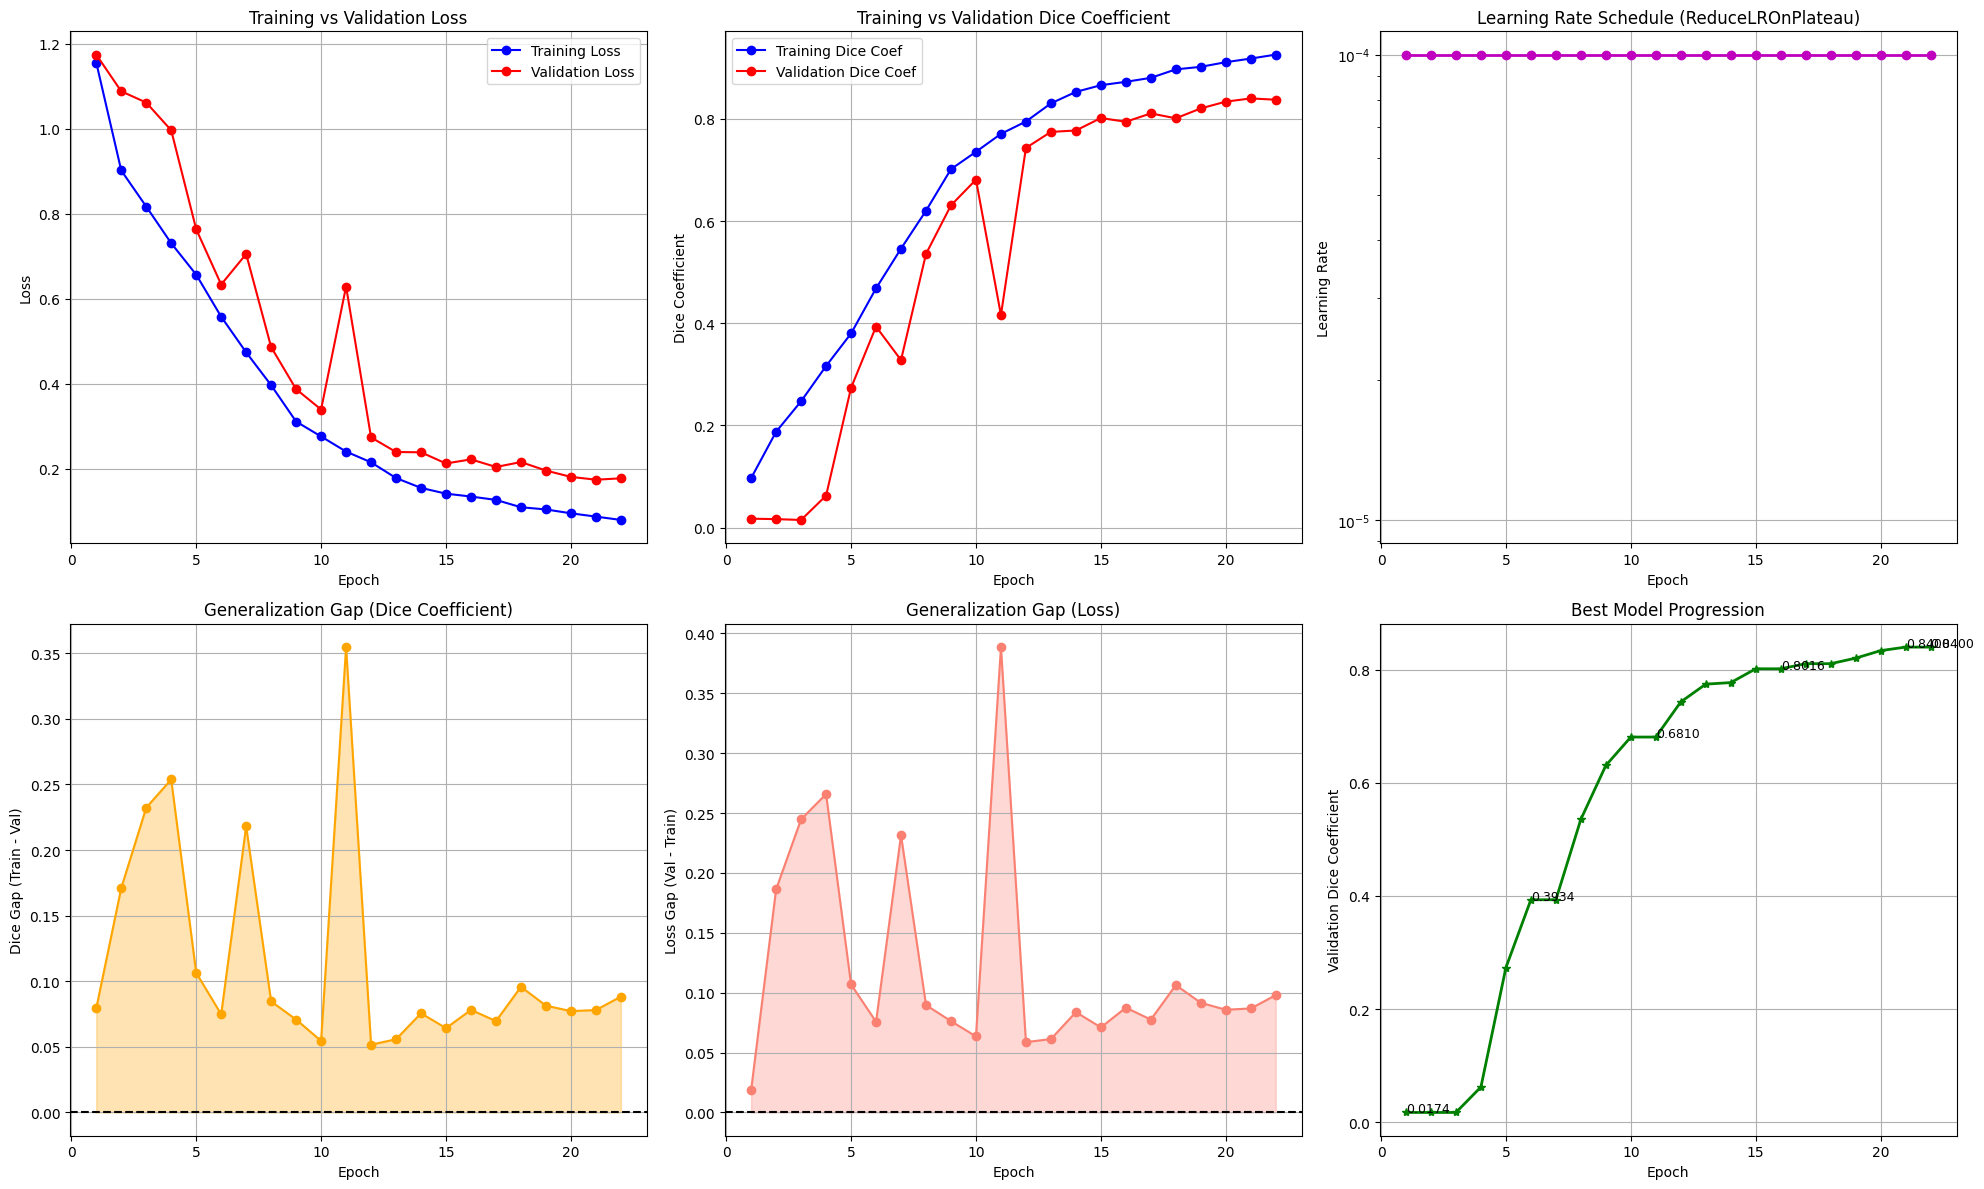

In [15]:
plt.figure(figsize=(20, 12))

# ---- 1. Training vs Validation Loss ----
plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

# ---- 2. Training vs Validation Dice ----
plt.subplot(2, 3, 2)
plt.plot(epochs, train_dice, 'bo-', label='Training Dice Coef')
plt.plot(epochs, val_dice, 'ro-', label='Validation Dice Coef')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.title('Training vs Validation Dice Coefficient')
plt.legend()
plt.grid(True)

# ---- 3. Learning Rate Schedule ----
plt.subplot(2, 3, 3)
plt.plot(epochs, lrs, 'mo-', linewidth=2)
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule (ReduceLROnPlateau)')
plt.grid(True)

# ---- 4. Dice Generalization Gap ----
plt.subplot(2, 3, 4)
plt.plot(epochs, dice_gap, color='orange', marker='o')
plt.fill_between(epochs, dice_gap, alpha=0.3, color='orange')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Epoch')
plt.ylabel('Dice Gap (Train - Val)')
plt.title('Generalization Gap (Dice Coefficient)')
plt.grid(True)

# ---- 5. Loss Generalization Gap ----
plt.subplot(2, 3, 5)
plt.plot(epochs, loss_gap, color='salmon', marker='o')
plt.fill_between(epochs, loss_gap, alpha=0.3, color='salmon')
plt.axhline(0, linestyle='--', color='black')
plt.xlabel('Epoch')
plt.ylabel('Loss Gap (Val - Train)')
plt.title('Generalization Gap (Loss)')
plt.grid(True)

# ---- 6. Best Model Progression ----
plt.subplot(2, 3, 6)
plt.plot(epochs, best_val_dice, 'g*-', linewidth=2)
for i, v in enumerate(best_val_dice):
    if i % 5 == 0 or i == len(best_val_dice) - 1:
        plt.text(i + 1, v, f"{v:.4f}", fontsize=9)
plt.xlabel('Epoch')
plt.ylabel('Validation Dice Coefficient')
plt.title('Best Model Progression')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
###COMPARISIONPLOTS###

In [16]:
import matplotlib.pyplot as plt

def plot_training(history):
    epochs = range(1, len(history.history['loss']) + 1)

# training vs epoch plots
    plt.figure(figsize=(6,5))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('accuracy_curve.png', dpi=300)
    plt.show()

    # loss plots
    plt.figure(figsize=(6,5))
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('loss_curve.png', dpi=300)
    plt.show()


    if 'mean_io_u' in history.history:
        plt.figure(figsize=(6,5))
        plt.plot(epochs, history.history['mean_io_u'], label='Training IoU')
        plt.plot(epochs, history.history['val_mean_io_u'], label='Validation IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.savefig('iou_curve.png', dpi=300)
        plt.show()

In [ ]:
#### BLAND ANALYSIS PLOTS

In [17]:
def compute_volumes(y_true, y_pred):
    """
    y_true, y_pred: binary masks (H, W) or (H, W, D)
    returns volume (number of positive pixels/voxels)
    """
    return np.sum(y_true), np.sum(y_pred)

In [18]:
gt_volumes = []
pred_volumes = []

threshold = 0.5
max_samples = 50

for i in range(max_samples):
    x = X_val[i:i+1]
    y_true = y_val[i].squeeze()

    y_prob = model.predict(x, verbose=0)[0, ..., 0]
    y_pred = (y_prob > threshold).astype(np.float32)

    gt_v, pred_v = compute_volumes(y_true, y_pred)

    gt_volumes.append(gt_v)
    pred_volumes.append(pred_v)

gt_volumes = np.array(gt_volumes)
pred_volumes = np.array(pred_volumes)

2026-02-02 11:58:12.947026: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [19]:
means = (gt_volumes + pred_volumes) / 2
diffs = pred_volumes - gt_volumes

mean_diff = np.mean(diffs)
std_diff = np.std(diffs)

loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

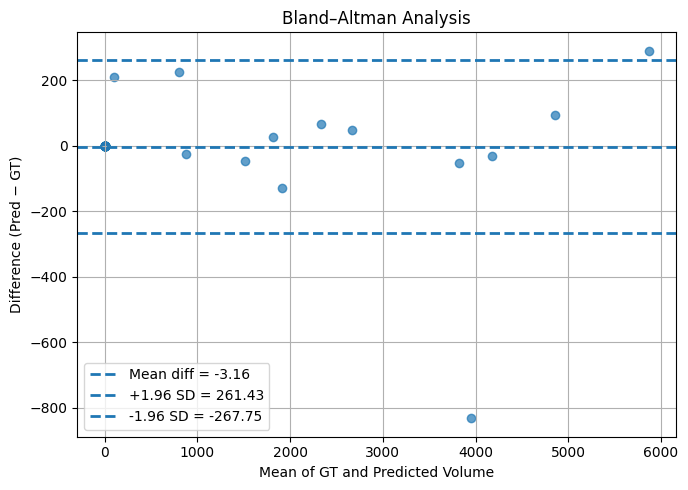

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

plt.scatter(means, diffs, alpha=0.7)
plt.axhline(mean_diff, linestyle='--', linewidth=2, label=f'Mean diff = {mean_diff:.2f}')
plt.axhline(loa_upper, linestyle='--', linewidth=2, label=f'+1.96 SD = {loa_upper:.2f}')
plt.axhline(loa_lower, linestyle='--', linewidth=2, label=f'-1.96 SD = {loa_lower:.2f}')

plt.xlabel('Mean of GT and Predicted Volume')
plt.ylabel('Difference (Pred − GT)')
plt.title('Bland–Altman Analysis')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('bland_altman_volume.png', dpi=300)
plt.show()
### for ground truth image this plot is needed

### Additional Visualizations - Test Set Analysis

In [21]:
# 1. Distribution of Metrics Across Test Set
print("Computing metrics for all test samples...")
test_dice, test_iou, test_prec, test_rec = [], [], [], []
test_f1, test_hd95, test_asd = [], [], []

threshold = 0.5

for i in range(len(X_test)):
    x = X_test[i:i+1]
    y_true = y_test[i].squeeze()
    
    y_prob = model.predict(x, verbose=0)[0, ..., 0]
    y_pred = (y_prob > threshold).astype(np.float32)
    
    test_dice.append(dice_np(y_true, y_pred))
    test_iou.append(iou_np(y_true, y_pred))
    test_prec.append(precision_np(y_true, y_pred))
    test_rec.append(recall_np(y_true, y_pred))
    test_f1.append(f1_np(y_true, y_pred))
    test_hd95.append(hd95_np(y_true, y_pred))
    test_asd.append(asd_np(y_true, y_pred))

print("✅ Metrics computed for all test samples")

Computing metrics for all test samples...


2026-02-02 11:58:43.170490: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2026-02-02 11:59:13.389614: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2026-02-02 11:59:43.615598: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2026-02-02 12:00:13.807295: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2026-02-02 12:00:44.082369: W tensorflow/core/framework/dataset.cc:9

✅ Metrics computed for all test samples


/tmp/ipykernel_427058/383599794.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(metrics_data.values(), labels=metrics_data.keys())
/tmp/ipykernel_427058/383599794.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([test_hd95, test_asd], labels=['HD95 (px)', 'ASD (px)'])


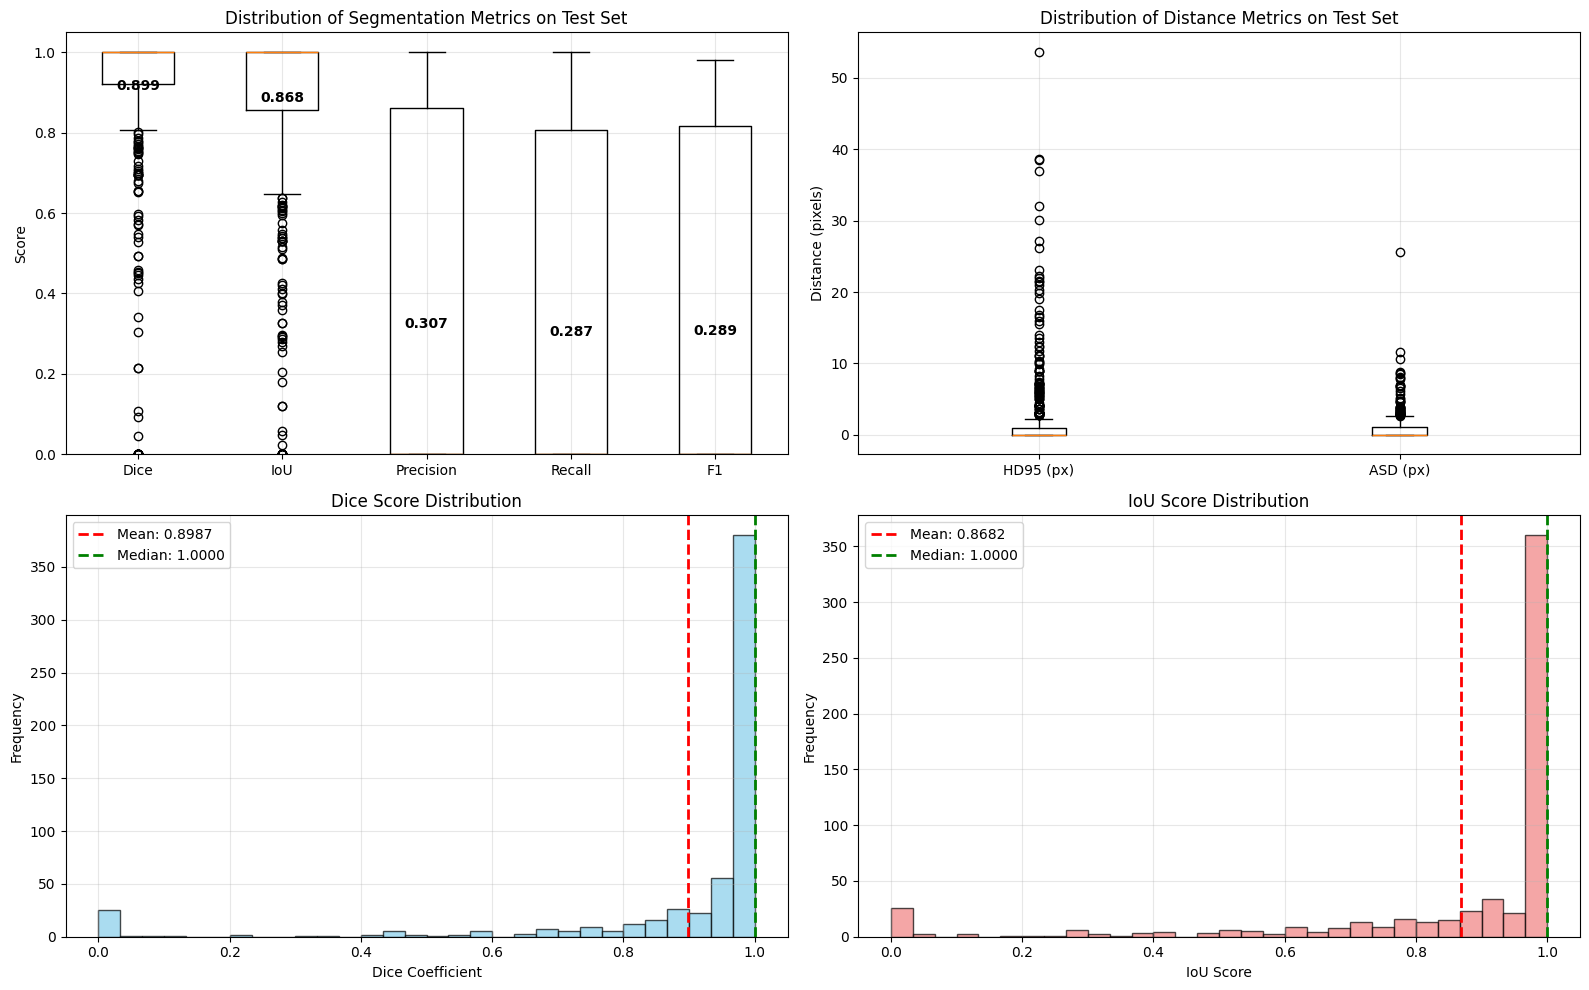

In [22]:
# 2. Box Plots for All Metrics
plt.figure(figsize=(16, 10))

metrics_data = {
    'Dice': test_dice,
    'IoU': test_iou,
    'Precision': test_prec,
    'Recall': test_rec,
    'F1': test_f1
}

# Subplot 1: Main segmentation metrics
plt.subplot(2, 2, 1)
plt.boxplot(metrics_data.values(), labels=metrics_data.keys())
plt.ylabel('Score')
plt.title('Distribution of Segmentation Metrics on Test Set')
plt.grid(True, alpha=0.3)
plt.ylim([0, 1.05])

# Add mean values
for i, (name, values) in enumerate(metrics_data.items(), 1):
    mean_val = np.mean(values)
    plt.text(i, mean_val, f'{mean_val:.3f}', ha='center', va='bottom', fontweight='bold')

# Subplot 2: Distance metrics
plt.subplot(2, 2, 2)
plt.boxplot([test_hd95, test_asd], labels=['HD95 (px)', 'ASD (px)'])
plt.ylabel('Distance (pixels)')
plt.title('Distribution of Distance Metrics on Test Set')
plt.grid(True, alpha=0.3)

# Subplot 3: Dice Score Distribution (Histogram)
plt.subplot(2, 2, 3)
plt.hist(test_dice, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(test_dice), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(test_dice):.4f}')
plt.axvline(np.median(test_dice), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(test_dice):.4f}')
plt.xlabel('Dice Coefficient')
plt.ylabel('Frequency')
plt.title('Dice Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 4: IoU Score Distribution (Histogram)
plt.subplot(2, 2, 4)
plt.hist(test_iou, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
plt.axvline(np.mean(test_iou), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(test_iou):.4f}')
plt.axvline(np.median(test_iou), color='green', linestyle='--', linewidth=2, label=f'Median: {np.median(test_iou):.4f}')
plt.xlabel('IoU Score')
plt.ylabel('Frequency')
plt.title('IoU Score Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('test_metrics_distribution.png', dpi=300)
plt.show()

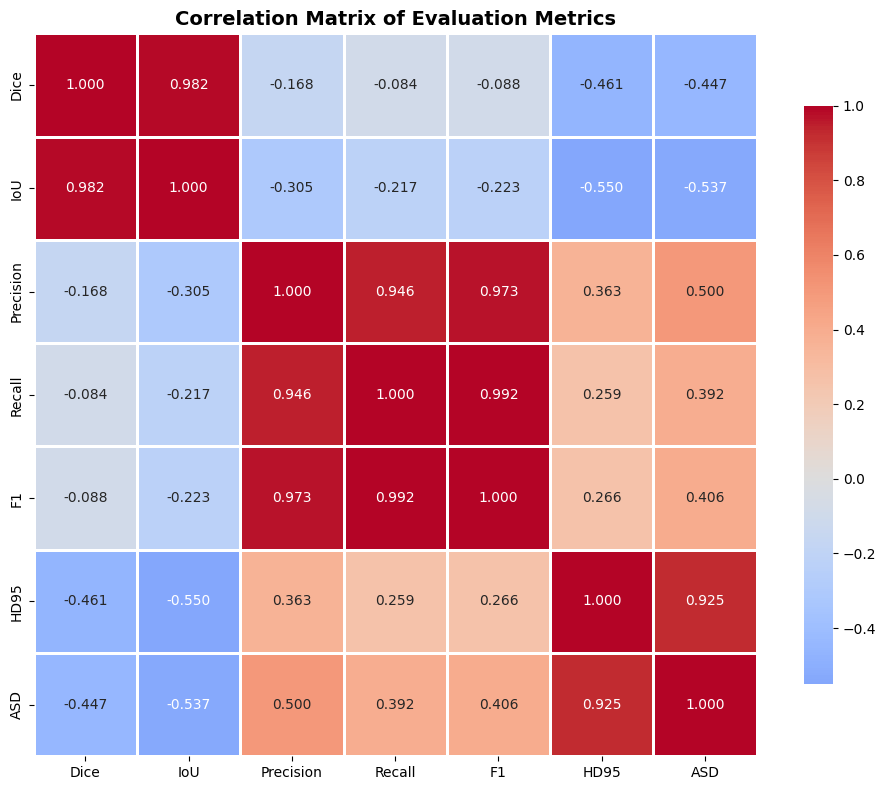

In [23]:
# 3. Correlation Heatmap Between Metrics
import pandas as pd
import seaborn as sns

metrics_df = {
    'Dice': test_dice,
    'IoU': test_iou,
    'Precision': test_prec,
    'Recall': test_rec,
    'F1': test_f1,
    'HD95': test_hd95,
    'ASD': test_asd
}

# Create correlation matrix
df = pd.DataFrame(metrics_df)
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Evaluation Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('metrics_correlation_heatmap.png', dpi=300)
plt.show()

2026-02-02 12:01:53.079393: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2026-02-02 12:02:23.385191: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2026-02-02 12:02:53.687561: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2026-02-02 12:03:23.977972: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2026-02-02 12:03:52.806346: W tensorflow/core/framework/dataset.cc:9

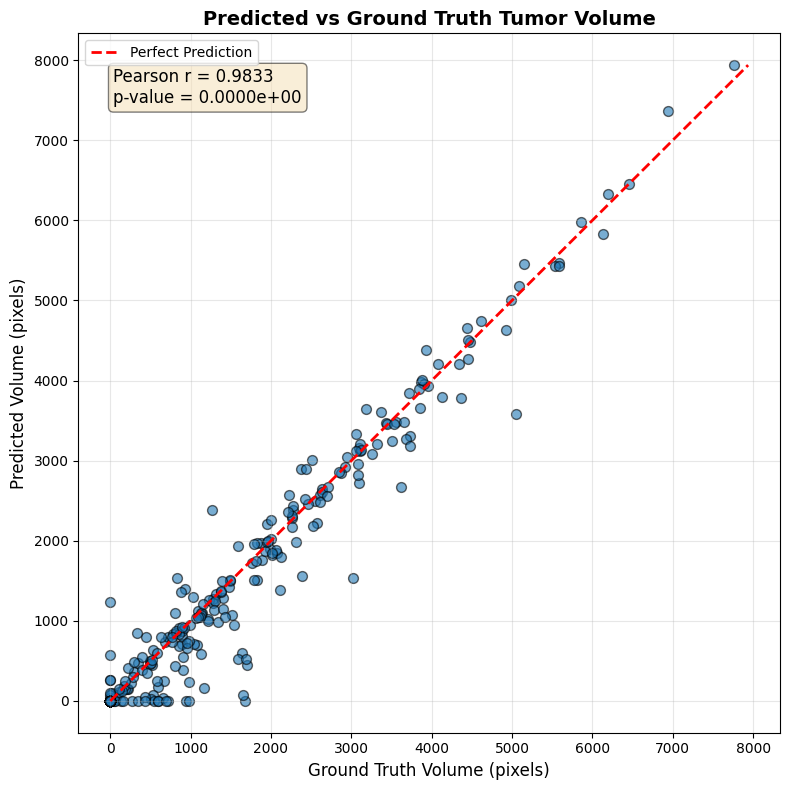

In [24]:
# 4. Scatter Plot: Predicted vs Ground Truth Volumes
from scipy.stats import pearsonr

gt_test_volumes = []
pred_test_volumes = []

for i in range(len(X_test)):
    x = X_test[i:i+1]
    y_true = y_test[i].squeeze()
    
    y_prob = model.predict(x, verbose=0)[0, ..., 0]
    y_pred = (y_prob > threshold).astype(np.float32)
    
    gt_v, pred_v = compute_volumes(y_true, y_pred)
    gt_test_volumes.append(gt_v)
    pred_test_volumes.append(pred_v)

gt_test_volumes = np.array(gt_test_volumes)
pred_test_volumes = np.array(pred_test_volumes)

plt.figure(figsize=(8, 8))
plt.scatter(gt_test_volumes, pred_test_volumes, alpha=0.6, s=50, edgecolors='black')

# Perfect prediction line
max_vol = max(gt_test_volumes.max(), pred_test_volumes.max())
plt.plot([0, max_vol], [0, max_vol], 'r--', linewidth=2, label='Perfect Prediction')

# Add correlation coefficient
corr, p_value = pearsonr(gt_test_volumes, pred_test_volumes)
plt.text(0.05, 0.95, f'Pearson r = {corr:.4f}\np-value = {p_value:.4e}', 
         transform=plt.gca().transAxes, fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.xlabel('Ground Truth Volume (pixels)', fontsize=12)
plt.ylabel('Predicted Volume (pixels)', fontsize=12)
plt.title('Predicted vs Ground Truth Tumor Volume', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('volume_scatter_plot.png', dpi=300)
plt.show()

/tmp/ipykernel_427058/3704349317.py:43: UserWarning: The following kwargs were not used by contour: 'label'
  axes[row, 3].contour(y_true, colors='green', linewidths=2, alpha=0.7, label='GT')
/tmp/ipykernel_427058/3704349317.py:44: UserWarning: The following kwargs were not used by contour: 'label'
  axes[row, 3].contour(y_pred, colors='red', linewidths=2, alpha=0.7, label='Pred')


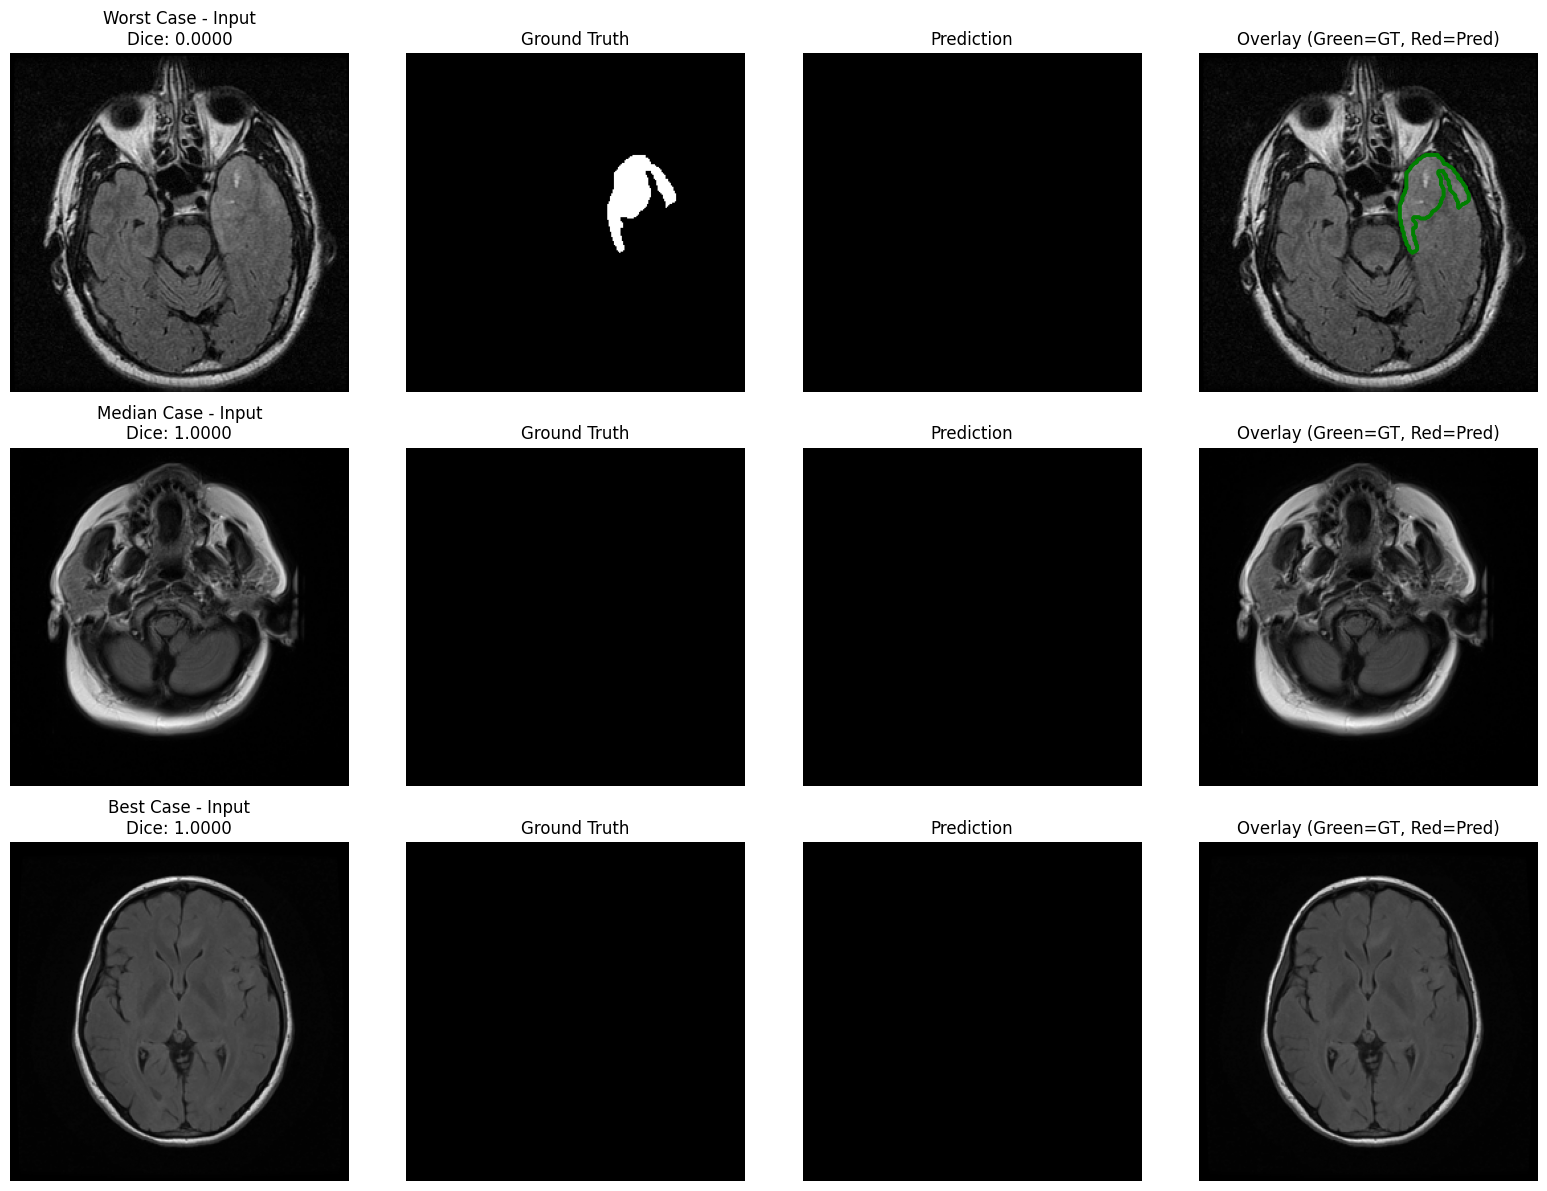

In [25]:
# 5. Best, Worst, and Median Predictions Visualization
# Find best, worst, and median cases based on Dice score
dice_with_idx = [(d, i) for i, d in enumerate(test_dice)]
dice_with_idx.sort(key=lambda x: x[0])

worst_idx = dice_with_idx[0][1]
median_idx = dice_with_idx[len(dice_with_idx)//2][1]
best_idx = dice_with_idx[-1][1]

fig, axes = plt.subplots(3, 4, figsize=(16, 12))

cases = [
    ('Worst', worst_idx, test_dice[worst_idx]),
    ('Median', median_idx, test_dice[median_idx]),
    ('Best', best_idx, test_dice[best_idx])
]

for row, (label, idx, dice_score) in enumerate(cases):
    x = X_test[idx:idx+1]
    y_true = y_test[idx].squeeze()
    
    y_prob = model.predict(x, verbose=0)[0, ..., 0]
    y_pred = (y_prob > threshold).astype(np.float32)
    
    # Original image
    axes[row, 0].imshow(X_test[idx].squeeze(), cmap='gray')
    axes[row, 0].set_title(f'{label} Case - Input\nDice: {dice_score:.4f}')
    axes[row, 0].axis('off')
    
    # Ground truth
    axes[row, 1].imshow(y_true, cmap='gray')
    axes[row, 1].set_title('Ground Truth')
    axes[row, 1].axis('off')
    
    # Prediction
    axes[row, 2].imshow(y_pred, cmap='gray')
    axes[row, 2].set_title('Prediction')
    axes[row, 2].axis('off')
    
    # Overlay
    overlay = X_test[idx].squeeze()
    axes[row, 3].imshow(overlay, cmap='gray')
    axes[row, 3].contour(y_true, colors='green', linewidths=2, alpha=0.7, label='GT')
    axes[row, 3].contour(y_pred, colors='red', linewidths=2, alpha=0.7, label='Pred')
    axes[row, 3].set_title('Overlay (Green=GT, Red=Pred)')
    axes[row, 3].axis('off')

plt.tight_layout()
plt.savefig('best_worst_median_predictions.png', dpi=300)
plt.show()

Generating probability predictions for ROC/PR curves...


2026-02-02 12:04:28.517844: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2026-02-02 12:04:58.763453: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2026-02-02 12:05:29.053491: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2026-02-02 12:05:59.209378: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2026-02-02 12:06:29.448600: W tensorflow/core/framework/dataset.cc:9

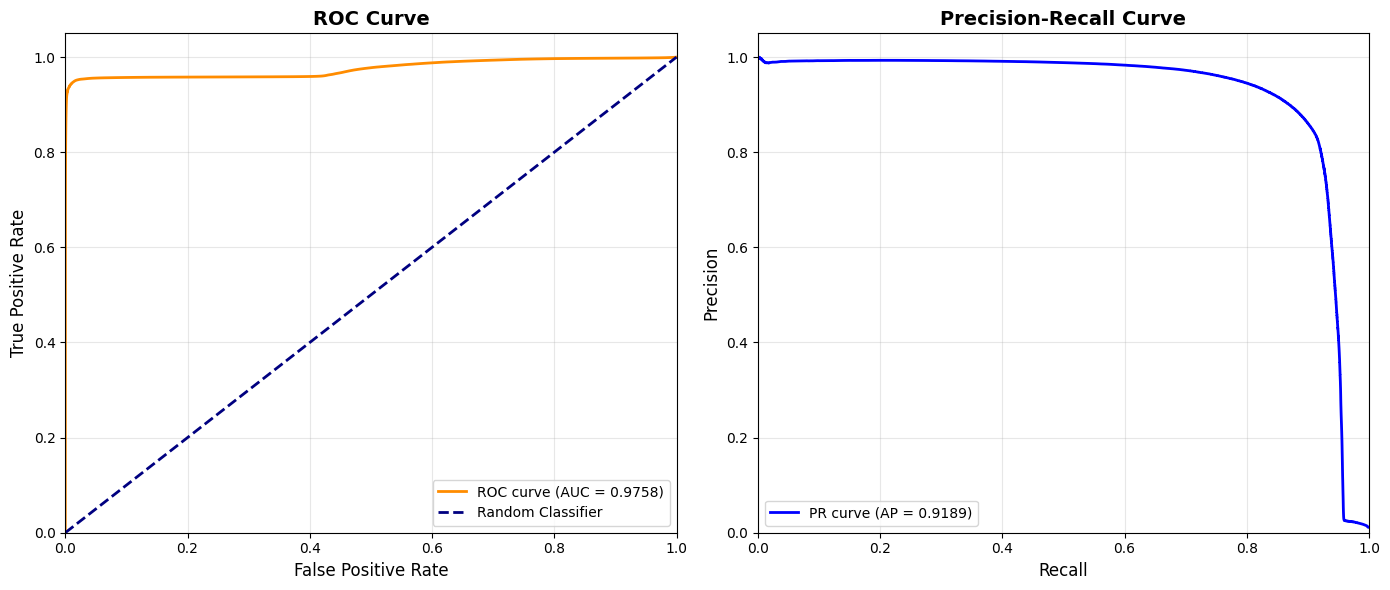


📊 ROC AUC: 0.9758
📊 Average Precision: 0.9189


In [26]:
# 6. ROC Curve and Precision-Recall Curve
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Collect all predictions and ground truths
all_y_true = []
all_y_pred_prob = []

print("Generating probability predictions for ROC/PR curves...")
for i in range(len(X_test)):
    x = X_test[i:i+1]
    y_true = y_test[i].squeeze()
    
    y_prob = model.predict(x, verbose=0)[0, ..., 0]
    
    all_y_true.extend(y_true.flatten())
    all_y_pred_prob.extend(y_prob.flatten())

all_y_true = np.array(all_y_true)
all_y_pred_prob = np.array(all_y_pred_prob)

# ROC Curve
fpr, tpr, thresholds_roc = roc_curve(all_y_true, all_y_pred_prob)
roc_auc = auc(fpr, tpr)

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(all_y_true, all_y_pred_prob)
avg_precision = average_precision_score(all_y_true, all_y_pred_prob)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.4f})')
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax2.legend(loc="lower left")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_pr_curves.png', dpi=300)
plt.show()

print(f"\n📊 ROC AUC: {roc_auc:.4f}")
print(f"📊 Average Precision: {avg_precision:.4f}")

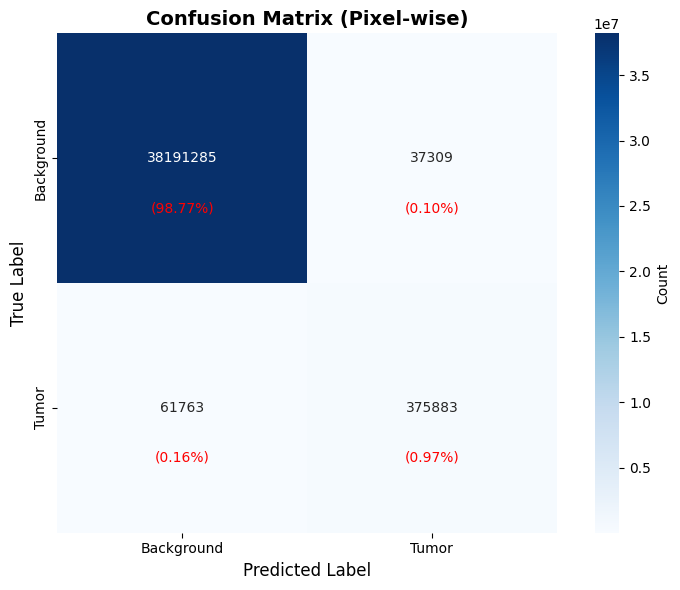


📊 Pixel-wise Metrics:
Sensitivity (Recall): 0.8589
Specificity: 0.9990


In [27]:
# 7. Confusion Matrix (Pixel-wise)
from sklearn.metrics import confusion_matrix

# Binarize predictions
all_y_pred_binary = (all_y_pred_prob > threshold).astype(int)

cm = confusion_matrix(all_y_true, all_y_pred_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, 
            xticklabels=['Background', 'Tumor'], 
            yticklabels=['Background', 'Tumor'],
            cbar_kws={'label': 'Count'})
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.title('Confusion Matrix (Pixel-wise)', fontsize=14, fontweight='bold')

# Add percentages
total = cm.sum()
for i in range(2):
    for j in range(2):
        percentage = (cm[i, j] / total) * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.2f}%)', 
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

# Calculate specificity
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"\n📊 Pixel-wise Metrics:")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Found 59 cases with Dice < 0.7


2026-02-02 12:09:14.130730: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


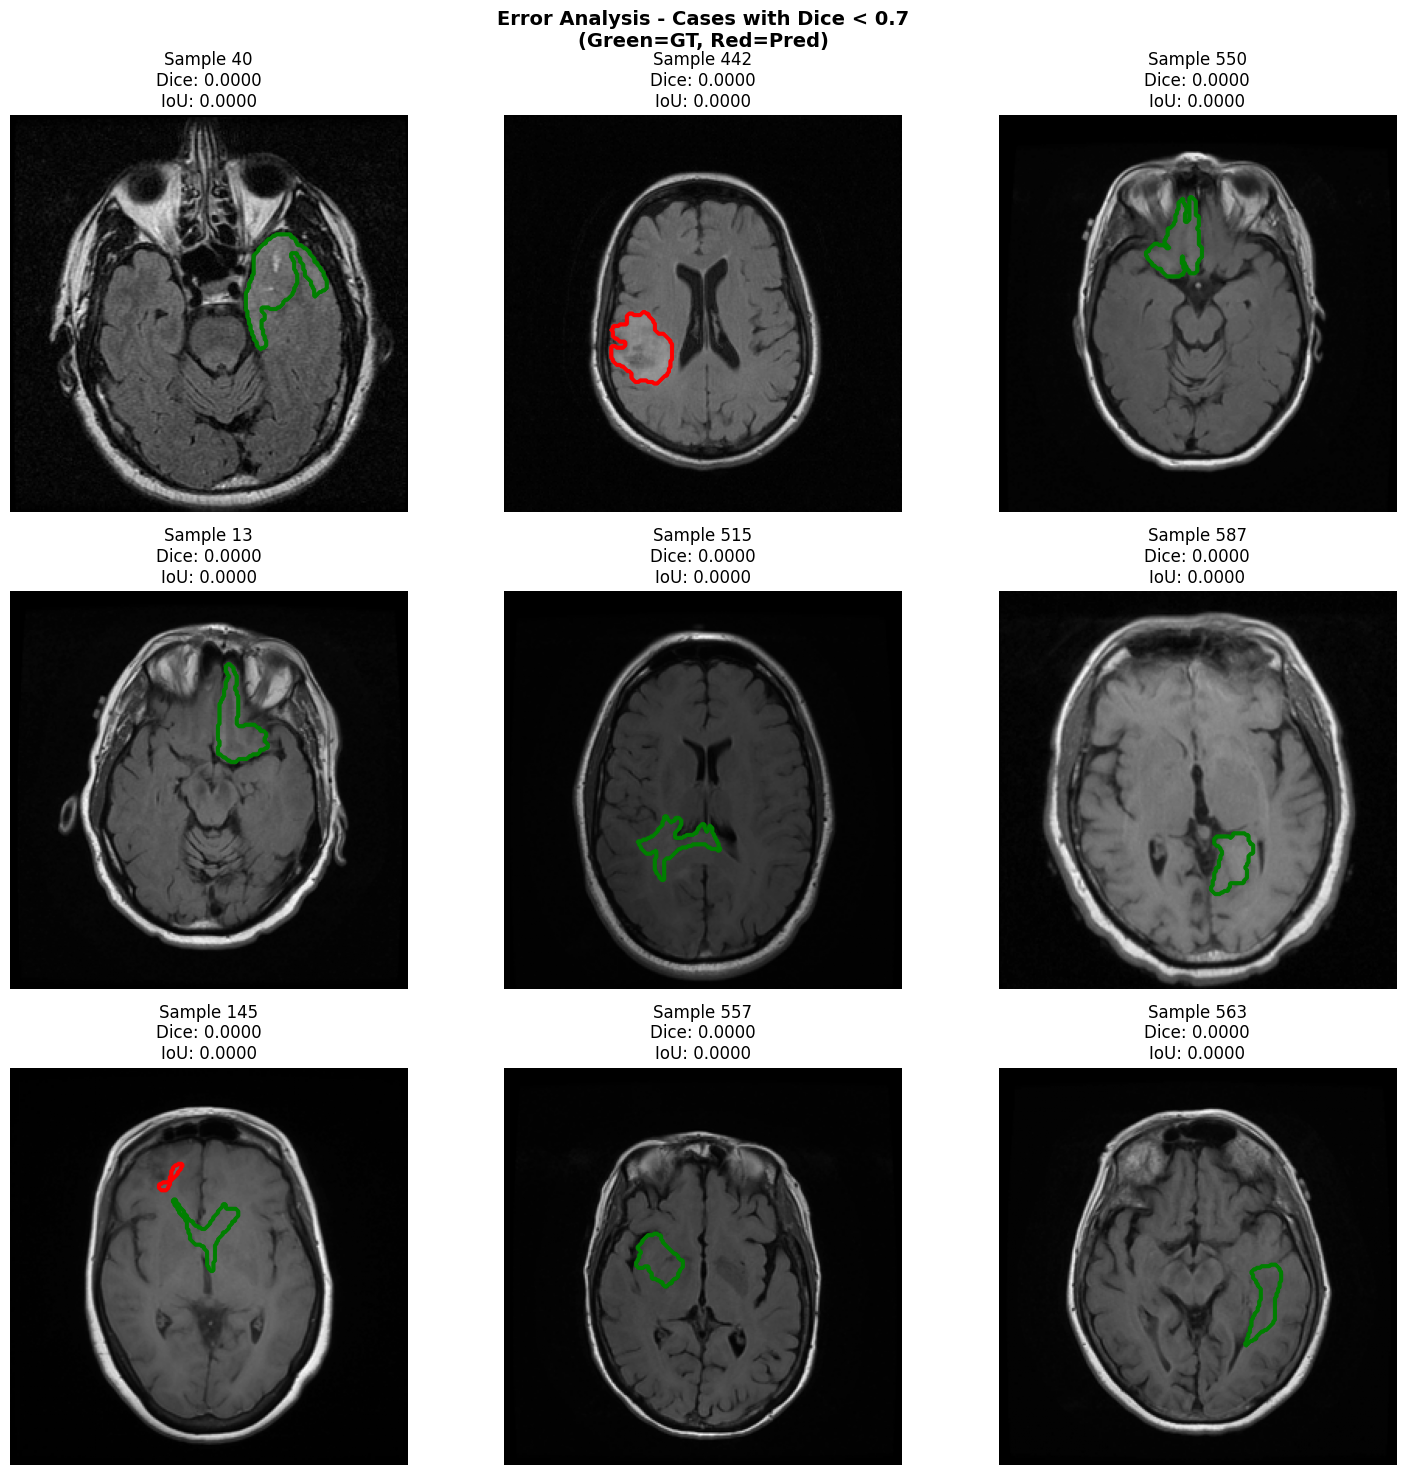

In [28]:
# 8. Error Analysis - Cases with Low Dice Scores
low_dice_threshold = 0.70
low_dice_cases = [(d, i) for i, d in enumerate(test_dice) if d < low_dice_threshold]

if len(low_dice_cases) > 0:
    print(f"Found {len(low_dice_cases)} cases with Dice < {low_dice_threshold}")
    
    # Visualize up to 9 low-performing cases
    n_display = min(9, len(low_dice_cases))
    low_dice_cases_sorted = sorted(low_dice_cases, key=lambda x: x[0])[:n_display]
    
    rows = int(np.ceil(n_display / 3))
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten() if n_display > 1 else [axes]
    
    for plot_idx, (dice_score, idx) in enumerate(low_dice_cases_sorted):
        x = X_test[idx:idx+1]
        y_true = y_test[idx].squeeze()
        
        y_prob = model.predict(x, verbose=0)[0, ..., 0]
        y_pred = (y_prob > threshold).astype(np.float32)
        
        # Overlay visualization
        overlay = X_test[idx].squeeze()
        axes[plot_idx].imshow(overlay, cmap='gray')
        axes[plot_idx].contour(y_true, colors='green', linewidths=2, alpha=0.7)
        axes[plot_idx].contour(y_pred, colors='red', linewidths=2, alpha=0.7)
        axes[plot_idx].set_title(f'Sample {idx}\nDice: {dice_score:.4f}\nIoU: {test_iou[idx]:.4f}')
        axes[plot_idx].axis('off')
    
    # Hide unused subplots
    for i in range(n_display, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Error Analysis - Cases with Dice < {low_dice_threshold}\n(Green=GT, Red=Pred)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('error_analysis_low_dice.png', dpi=300)
    plt.show()
else:
    print(f"✅ All test cases have Dice >= {low_dice_threshold}!")

In [29]:
# 9. Comprehensive Summary Statistics Table
import pandas as pd

print("\n" + "="*60)
print("📊 COMPREHENSIVE TEST SET EVALUATION SUMMARY")
print("="*60)

summary_stats = {
    'Metric': ['Dice Coefficient', 'IoU', 'Precision', 'Recall', 'F1 Score', 
               'HD95 (pixels)', 'ASD (pixels)', 'Specificity'],
    'Mean': [
        np.mean(test_dice), 
        np.mean(test_iou), 
        np.mean(test_prec), 
        np.mean(test_rec), 
        np.mean(test_f1),
        np.mean(test_hd95), 
        np.mean(test_asd),
        specificity
    ],
    'Std': [
        np.std(test_dice), 
        np.std(test_iou), 
        np.std(test_prec), 
        np.std(test_rec), 
        np.std(test_f1),
        np.std(test_hd95), 
        np.std(test_asd),
        0  # Single value
    ],
    'Median': [
        np.median(test_dice), 
        np.median(test_iou), 
        np.median(test_prec), 
        np.median(test_rec), 
        np.median(test_f1),
        np.median(test_hd95), 
        np.median(test_asd),
        specificity
    ],
    'Min': [
        np.min(test_dice), 
        np.min(test_iou), 
        np.min(test_prec), 
        np.min(test_rec), 
        np.min(test_f1),
        np.min(test_hd95), 
        np.min(test_asd),
        specificity
    ],
    'Max': [
        np.max(test_dice), 
        np.max(test_iou), 
        np.max(test_prec), 
        np.max(test_rec), 
        np.max(test_f1),
        np.max(test_hd95), 
        np.max(test_asd),
        specificity
    ]
}

summary_df = pd.DataFrame(summary_stats)
print(summary_df.to_string(index=False))
print("="*60)

# Save to CSV
summary_df.to_csv('test_evaluation_summary.csv', index=False)
print("\n✅ Summary saved to 'test_evaluation_summary.csv'")


📊 COMPREHENSIVE TEST SET EVALUATION SUMMARY
          Metric     Mean      Std   Median          Min       Max
Dice Coefficient 0.898746 0.231110 1.000000 5.959476e-10  1.000000
             IoU 0.868170 0.252590 1.000000 5.959476e-10  1.000000
       Precision 0.306569 0.427763 0.000000 0.000000e+00  1.000000
          Recall 0.286593 0.411036 0.000000 0.000000e+00  1.000000
        F1 Score 0.288576 0.409524 0.000000 0.000000e+00  0.981701
   HD95 (pixels) 1.932496 5.475802 0.000000 0.000000e+00 53.679411
    ASD (pixels) 0.819911 1.854390 0.000000 0.000000e+00 25.627262
     Specificity 0.999024 0.000000 0.999024 9.990241e-01  0.999024

✅ Summary saved to 'test_evaluation_summary.csv'


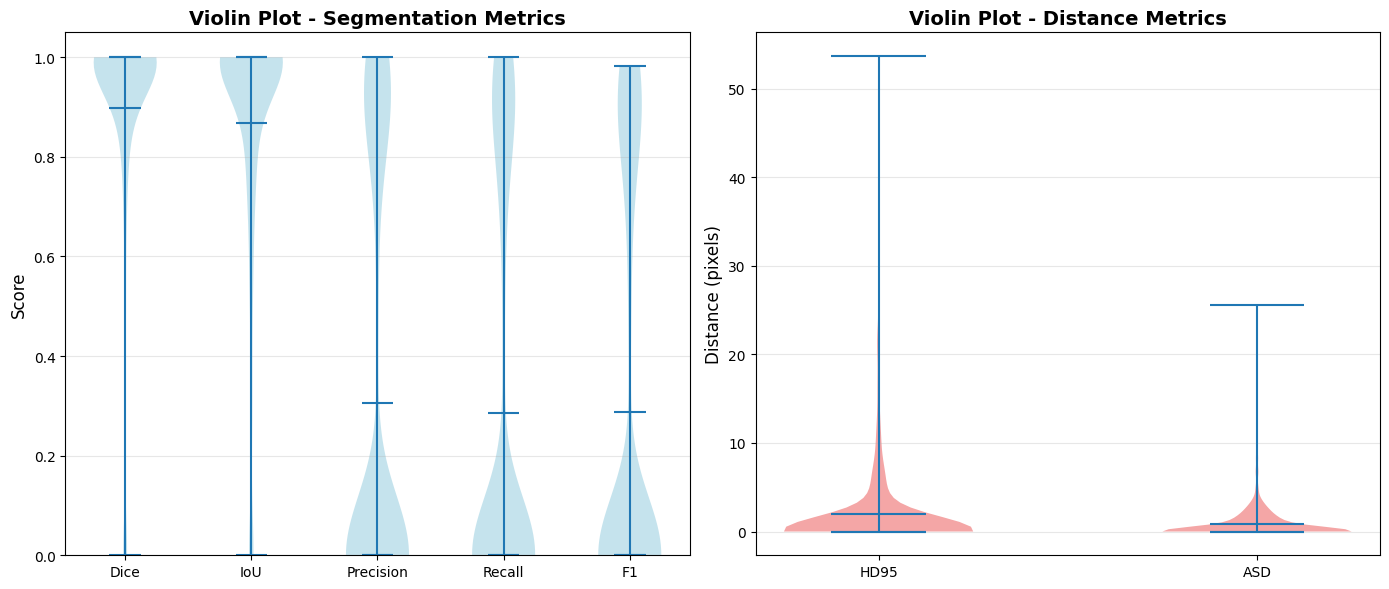

In [30]:
# 10. Violin Plot - Detailed Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Segmentation metrics violin plot
ax1 = axes[0]
parts1 = ax1.violinplot([test_dice, test_iou, test_prec, test_rec, test_f1], 
                         positions=range(1, 6), showmeans=True, showmedians=True)

for pc in parts1['bodies']:
    pc.set_facecolor('lightblue')
    pc.set_alpha(0.7)

ax1.set_xticks(range(1, 6))
ax1.set_xticklabels(['Dice', 'IoU', 'Precision', 'Recall', 'F1'])
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Violin Plot - Segmentation Metrics', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim([0, 1.05])

# Distance metrics violin plot
ax2 = axes[1]
parts2 = ax2.violinplot([test_hd95, test_asd], positions=[1, 2], 
                         showmeans=True, showmedians=True)

for pc in parts2['bodies']:
    pc.set_facecolor('lightcoral')
    pc.set_alpha(0.7)

ax2.set_xticks([1, 2])
ax2.set_xticklabels(['HD95', 'ASD'])
ax2.set_ylabel('Distance (pixels)', fontsize=12)
ax2.set_title('Violin Plot - Distance Metrics', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('violin_plots_metrics.png', dpi=300)
plt.show()